In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_validate 
import itertools
from sklearn.tree import plot_tree
from sklearn.ensemble import ExtraTreesRegressor # et모델
from sklearn.tree import DecisionTreeRegressor # dt모델
from xgboost import XGBRFRegressor # xgb모델
!pip install catboost
from catboost import CatBoostRegressor # catb모델

# for dataloading
train = pd.read_csv('train.csv', encoding = 'cp949')
test = pd.read_csv('test.csv', encoding = 'cp949')

# 오류 데이터 삭제
error_data = ['C2085', 'C1397', 'C2431', 'C1649', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
for error in error_data:
    error_index = train[train['단지코드'] == error].index
    train.drop(error_index, inplace=True)

# for 중복값 제거
train = train.drop_duplicates()
test = test.drop_duplicates()

# for 아파트이면서 공공분양이 아닌 데이터만 사용
train = train[(train.임대건물구분 == '아파트') & (train.공급유형 != '공공분양')]
test = test[(test.임대건물구분 == '아파트') & (test.공급유형 != '공공분양')]

# 임대보증금과 임대료 타입 float로 변환
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-','임대보증금' ] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)
train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

# 공급유형이 장기전세면 임대료 = 0
train.loc[(train.공급유형=='장기전세')&(train.임대료.isnull()), '임대료']=0

# 지하철역과 버스 정류장의 NULL값의 경우, 0으로 판단, 밑에서 컬럼명 바꿈(지하철, 버스)
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0, inplace=True)
train['도보 10분거리 내 버스정류장 수'].fillna(0, inplace=True)

test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0, inplace=True)
test['도보 10분거리 내 버스정류장 수'].fillna(0, inplace=True)

# test의 자격유형에 있는 2개 결측치 채우기
test.loc[(test.단지코드=='C2411')&(test.자격유형.isnull()), '자격유형'] = 'A'
test.loc[(test.단지코드=='C2253')&(test.자격유형.isnull()), '자격유형'] = 'C'

# train 강원도 행복주택

# 전용면적 16.91 
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 16.91), '임대보증금'] = 13450000
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 16.91), '임대료'] = 65500
# 전용면적 26.9
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대보증금'] = 19700000
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대료'] = 96000
# 전용면적 26.9
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대보증금'] = 19150000
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대료'] = 94000
# 전용면적 26.9
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대보증금'] = 21400000
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대료'] = 105000

# train 부산 국민임대

# 전용면적 24.72
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 24.72), '임대보증금'] = 7000000
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 24.72), '임대료'] = 135000
# 전용면적 24.79
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 24.79), '임대보증금'] = 7000000
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 24.79), '임대료'] = 135000
# 전용면적 26.83
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 26.83), '임대보증금'] = 7600000
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 26.83), '임대료'] = 142000
# 전용면적 37.7
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 37.7), '임대보증금'] = 14800000
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 37.7), '임대료'] = 198000
# 전용면적 46.94
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 46.94), '임대보증금'] = 23100000
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 46.94), '임대료'] = 259000

# train 대구 국민임대

# 전용면적 29.17
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 29.17), '임대보증금'] = 10847000
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 29.17), '임대료'] = 138600
# 전용면적 29.34
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 29.34), '임대보증금'] = 10847000
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 29.34), '임대료'] = 138600
# 전용면적 37.43
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 37.43), '임대보증금'] = 17338000
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 37.43), '임대료'] = 197500

# test 대전 임대상가

# 전용면적 26.37
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 26.37), '임대보증금'] = 5787000
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 26.37), '임대료'] = 79980
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 26.37), '자격유형'] = 'C'
# 전용면적 52.74
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 52.74), '임대보증금'] = 11574000
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 52.74), '임대료'] = 159960
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 52.74), '자격유형'] = 'C'

# test 강원도 영구임대

# 전용면적 24.83
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 24.83), '임대보증금'] = 2129000
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 24.83), '임대료'] = 42350
# 전용면적 33.84
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 33.84), '임대보증금'] = 2902000
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 33.84), '임대료'] = 57730

# test 경상남도 행복주택

# 전용면적 16.94
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 16.94), '임대보증금'] = 11200000
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 16.94), '임대료'] = 53200
# 전용면적 26.85
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대보증금'] = 16333330
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대료'] = 77580
# 전용면적 26.85
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대보증금'] = 18620000
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대료'] = 88440
# 전용면적 36.77
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 36.77), '임대보증금'] = 23760000
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 36.77), '임대료'] = 112860

# 데이터프레임 컬럼명 변경(버스,지하철 컬럼명이 너무 길어서 변경)
train.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형',
    '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금',
    '임대료', '지하철', '버스', '단지내주차면수', '등록차량수']
test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형',
    '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금',
    '임대료', '지하철', '버스', '단지내주차면수']

# train 공급유형
train.loc[train['공급유형'].isin(['국민임대']),'공급유형그룹'] = '국민임대'
train.loc[train['공급유형'].isin(['공공임대(50년)']),'공급유형그룹'] = '장기공공임대'
train.loc[train['공급유형'].isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)']),'공급유형그룹'] = '단기공공임대'
train.loc[train['공급유형'].isin(['행복주택', '영구임대', '장기전세']), '공급유형그룹'] = '저소득층'

# test 공급유형
test.loc[test['공급유형'].isin(['국민임대']),'공급유형그룹'] = '국민임대'
test.loc[test['공급유형'].isin(['공공임대(50년)']),'공급유형그룹'] = '장기공공임대'
test.loc[test['공급유형'].isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)']),'공급유형그룹'] = '단기공공임대'
test.loc[test['공급유형'].isin(['행복주택', '영구임대', '장기전세']), '공급유형그룹'] = '저소득층'

train = train.drop(labels='공급유형', axis=1)
test = test.drop(labels='공급유형', axis=1)

# train 지역
train.insert(4, 'n지역','')
train.loc[(train['지역'] == '강원도') | (train['지역'] == '제주특별자치도') | (train['지역'] == '충청남도') | (train['지역'] == '울산광역시'), 'n지역'] = 0
train.loc[(train['지역'] == '전라남도') | (train['지역'] == '전라북도') | (train['지역'] == '경상남도'), 'n지역'] = 1
train.loc[(train['지역'] == '부산광역시') | (train['지역'] == '충청북도') | (train['지역'] == '경상북도'), 'n지역'] = 2
train.loc[(train['지역'] == '대전광역시') | (train['지역'] == '광주광역시') | (train['지역'] == '서울특별시'), 'n지역'] = 3
train.loc[(train['지역'] == '경기도') | (train['지역'] == '대구광역시') | (train['지역'] == '세종특별자치시'), 'n지역'] = 4

# test 지역
test.insert(4, 'n지역','')
test.loc[(test['지역'] == '강원도') | (test['지역'] == '제주특별자치도') | (test['지역'] == '충청남도') | (test['지역'] == '울산광역시'), 'n지역'] = 0
test.loc[(test['지역'] == '전라남도') | (test['지역'] == '전라북도') | (test['지역'] == '경상남도'), 'n지역'] = 1
test.loc[(test['지역'] == '부산광역시') | (test['지역'] == '충청북도') | (test['지역'] == '경상북도'), 'n지역'] = 2
test.loc[(test['지역'] == '대전광역시') | (test['지역'] == '광주광역시') | (test['지역'] == '서울특별시'), 'n지역'] = 3
test.loc[(test['지역'] == '경기도') | (test['지역'] == '대구광역시') | (test['지역'] == '세종특별자치시'), 'n지역'] = 4


train = train.drop(labels='지역', axis=1)
test = test.drop(labels='지역', axis=1)

# train 자격유형
train.loc[train['자격유형'].isin(['E','H','I','J']),'자격유형그룹'] = 'q1'
train.loc[train['자격유형'].isin(['B','L']),'자격유형그룹'] = 'q2'
train.loc[train['자격유형'].isin(['G','K','M','N','O']),'자격유형그룹'] = 'q3'
train.loc[train['자격유형'].isin(['D','C','F']),'자격유형그룹'] = 'q4'
train.loc[train['자격유형'].isin(['A']),'자격유형그룹'] = 'q5'

# test 자격유형
test.loc[test['자격유형'].isin(['E','H','I','J']),'자격유형그룹'] = 'q1'
test.loc[test['자격유형'].isin(['B','L']),'자격유형그룹'] = 'q2'
test.loc[test['자격유형'].isin(['G','K','M','N','O']),'자격유형그룹'] = 'q3'
test.loc[test['자격유형'].isin(['D','C','F']),'자격유형그룹'] = 'q4'
test.loc[test['자격유형'].isin(['A']),'자격유형그룹'] = 'q5'

train = train.drop(labels='자격유형', axis=1)
test = test.drop(labels='자격유형', axis=1)

# 데이터프레임 인덱스 재정의
train.reset_index(drop=False, inplace=True)
test.reset_index(drop=False, inplace=True)

# 원-핫 인코딩
from sklearn.preprocessing import OneHotEncoder

train = pd.get_dummies(train, columns = ['n지역','공급유형그룹','자격유형그룹'])
test =  pd.get_dummies(test, columns = ['n지역','공급유형그룹','자격유형그룹'])

# 뒤에 단지코드 컬럼 쓰기위해 리스트로 저장
code = test[['단지코드']]
code = code.values.tolist() 

train = train[['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '지하철', '버스',
       '단지내주차면수', 'n지역_0', 'n지역_1', 'n지역_2', 'n지역_3', 'n지역_4',
       '공급유형그룹_국민임대', '공급유형그룹_단기공공임대', '공급유형그룹_장기공공임대', '공급유형그룹_저소득층',
       '자격유형그룹_q1', '자격유형그룹_q2', '자격유형그룹_q3', '자격유형그룹_q4', '자격유형그룹_q5', '등록차량수']]
test = test[['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '지하철', '버스',
       '단지내주차면수', 'n지역_0', 'n지역_1', 'n지역_2', 'n지역_3', 'n지역_4', '공급유형그룹_국민임대',
       '공급유형그룹_단기공공임대', '공급유형그룹_장기공공임대', '공급유형그룹_저소득층', '자격유형그룹_q1',
       '자격유형그룹_q2', '자격유형그룹_q3', '자격유형그룹_q4', '자격유형그룹_q5']]

############################################################
#######################전처리 완료##########################
############################################################

# train데이터에서  data, target 지정 
from sklearn.model_selection import train_test_split 

data = train.drop(columns=['등록차량수'])
target = train['등록차량수']

# train세트와 test세트로 나누기
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 3.7 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/usr/local/lib/python3.9/dist-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [ ]:
#릿지모델
from sklearn.linear_model import Ridge 
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)

# 데이터 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_poly)
train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

ridge = Ridge(alpha=10, random_state=42)
ridge.fit(train_scaled, train_target)
score = cross_validate(ridge, train_scaled, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(score['train_score']), np.mean(score['test_score']))

rm1= np.mean(score['train_score'])
rm2= np.mean(score['test_score'])

0.9550568381342723 0.8976024748597056


In [ ]:
#선형회귀

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2, include_bias=False)
train_poly = poly.fit_transform(train_input)
test_poly = poly.fit_transform(test_input)
model4 = LinearRegression()
model4.fit(train_poly, train_target)
score = cross_validate(model4, train_poly, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(score['train_score']), np.mean(score['test_score'])) 

Lrm1 = np.mean(score['train_score'])
Lrm2 = np.mean(score['test_score'])

0.8910373749197268 0.8596622033562236


In [ ]:
# 엑스트라트리 모델
et = ExtraTreesRegressor()
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1) 

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

etm1 = np.mean(scores['train_score'])
etm2 = np.mean(scores['test_score'])

1.0 0.9939397607569382


In [ ]:
# xb부스트 모델
xgb = XGBRFRegressor(tree_method='hist',random_state=42)
scores = cross_validate(xgb,train_input,train_target,return_train_score=True,n_jobs=-1)

print(np.mean(scores['train_score']),np.mean(scores['test_score']))

xgbm1 = np.mean(scores['train_score'])
xgbm2 = np.mean(scores['test_score'])

0.9218969280045585 0.9051601926109412


In [ ]:
# 결정트리 모델
dt = DecisionTreeRegressor(random_state=42) 
scores = cross_validate(dt, train_input, train_target, return_train_score=True, n_jobs=-1) 

print(np.mean(scores['train_score']), np.mean(scores['test_score'])) 

dtm1 = np.mean(scores['train_score'])
dtm2 = np.mean(scores['test_score'])

1.0 0.9722999236844387


In [ ]:
# catboost 모델
catb = CatBoostRegressor(
    loss_function='MAE',
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)
scores = cross_validate(catb, train_input, train_target, return_train_score=True, n_jobs=-1) 

print(np.mean(scores['train_score']), np.mean(scores['test_score'])) 

catbm1 = np.mean(scores['train_score'])
catbm2 = np.mean(scores['test_score'])

0.9646828277403863 0.9397068142398881


In [ ]:
x = [rm1,Lrm1,etm1,xgbm1,dtm1,catbm1]
y = [rm2,Lrm2,etm2,xgbm2,dtm2,catbm2]

In [ ]:
import plotly.express as px
ticklabel = ['Ridge', 'LinearRegressor','ExtraTreesRegressor', 'XGBRFRegressor','DecisionTreeRegressor','CatBoostRegressor']
df = pd.DataFrame({'Model': ticklabel, 'train_score': x, 'test_score': y})
fig = px.bar(df, x='Model', y=['train_score', 'test_score'], barmode='group',
             title='모델별 score값', labels={'value': 'score', 'variable': 'Data Type', 'Model': '머신러닝 모델'})
fig.show()

In [ ]:
index = np.arange(4)
ticklabel = ['ExtraTreesRegressor', 'XGBRFRegressor','DecisionTreeRegressor','CatBoostRegressor']
plt.bar(index+0.00, x, width=0.25)
plt.bar(index+0.25, y, width=0.25)
plt.ylim(0.8,1.05)
plt.title('모델별 score값')
plt.xlabel('머신러닝 모델')
plt.ylabel('score')

plt.xticks(index, ticklabel, rotation=30)  # 라벨을 30도 회전시킵니다.
plt.show()

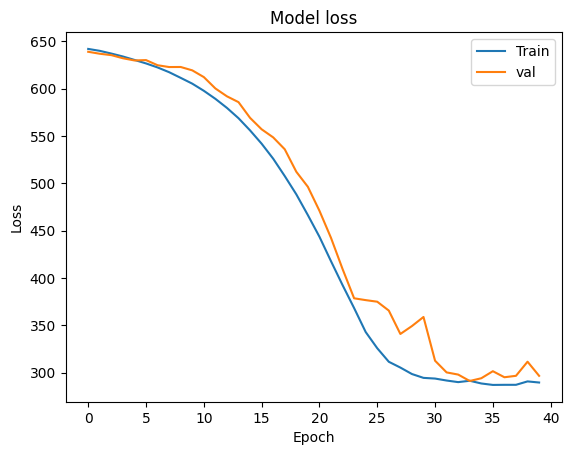

In [ ]:
# 신경망 모델
X = tf.keras.layers.Input(shape=[23])

H = tf.keras.layers.Dense(128)(X)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.relu)(H)
H = tf.keras.layers.Dropout(0.4)(H)

H = tf.keras.layers.Dense(256)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.relu)(H)
H = tf.keras.layers.Dropout(0.4)(H)

Y = tf.keras.layers.Dense(1)(H)
model = tf.keras.models.Model(X, Y)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss='mae', optimizer=sgd) # loss='mse'는 회귀, mae < 이게 더 잘 돌아감

history = model.fit(train_input, train_target, epochs=40, batch_size=128, validation_split=0.2, verbose=0) # 모델 훈련

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'val'], loc='upper right')
plt.show()